In [82]:
# Base import and functions

import imutils
import cv2
from imutils import contours

from tqdm import tqdm

import pytesseract             # Python interface to tesseract for OCR

import numpy as np
from PIL import Image

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


def excise_segmentation(image):
    
    resized = imutils.resize(excise_src, height=500)
    
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    equ = cv2.equalizeHist(gray)
    # blurred = cv2.medianBlur(equ, 3)
    blurred = cv2.GaussianBlur(equ, (3, 3), 0)
    _, thresholded = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
 
    # return the segmentationed image
    return resized, equ, thresholded


def appendROICnts(
    ROISizedCnts, 
    baseIndex, 
    ROICnts, 
    UsedROICandidate, 
    groupCount, 
    iterations, 
    x, y, w, h, 
    dimension,
    image,
    colors):

    ROICntsCandidate = []
    compareIndex = 0
    for compC in ROISizedCnts:
        # already used
        if (compareIndex in UsedROICandidate):
            compareIndex += 1
            continue

        iterations += 1
        (cx, cy, cw, ch) = cv2.boundingRect(compC)
        # Contours are close and same enought
        if (((abs(x - cx) < 15) and (abs((x + w) - (cx + cw)) < 15) and (abs(w - cw) < 15) and (dimension == 'x')) or 
           ((abs(y - cy) < 15) and (abs((y + h) - (cy + ch)) < 15) and (abs(h - ch) < 15) and (dimension == 'y'))):
            ROICntsCandidate.append(compareIndex)
        
        compareIndex += 1
    
    if (len(ROICntsCandidate) > 8):  # 9 digits
        groupROICnts = []
        for index in ROICntsCandidate:  # add to ROI
            iterations += 1
            groupROICnts.append(ROISizedCnts[index])
            (x2, y2, w2, h2) = cv2.boundingRect(ROISizedCnts[index])
            cv2.rectangle(image, (x2, y2), (x2 + w2, y2 + h2), colors[groupCount], 2)
            if (index != baseIndex):
                UsedROICandidate.append(index)  # remove trash from base array
            else:
                if (dimension == 'y'):
                    UsedROICandidate.append(index)
        groupCount += 1
        if (dimension == 'x'):
            ROICnts.append({ 'orientation': 'vertical', 'contours': contours.sort_contours(groupROICnts, method="bottom-to-top")[0] })
        if (dimension == 'y'):
            ROICnts.append({ 'orientation': 'horisontal', 'contours': contours.sort_contours(groupROICnts, method="left-to-right")[0] })
                    
    return ROICnts, UsedROICandidate, groupCount, iterations, image


def select_contours(thresholded):
    
    refCnts = cv2.findContours(cv2.Canny(thresholded, 30, 200).copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
    
    width, height = thresholded.shape[:2]
    clone = np.dstack([thresholded.copy()] * 3)
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255)]
    
    ROISizedCnts = []
    ROICnts = []
    iterations = 0

    # size filter
    for c in refCnts:
        iterations += 1
        (x, y, w, h) = cv2.boundingRect(c)
        if ((w < width / 9) and (h < height / 9 ) and (w > 7) and (h > 7)):  # 9 digits in serial must be on image
            ROISizedCnts.append(c)

    # positionin filter
    UsedROICandidate = []
    baseIndex = 0
    groupCount = 0
    for c in ROISizedCnts:  
        # already used
        if (baseIndex in UsedROICandidate): 
            baseIndex += 1
            continue

        iterations += 1       
        (x, y, w, h) = cv2.boundingRect(c)   

        # Compare for x dimension
        ROICnts, UsedROICandidate, groupCount, iterations, clone = appendROICnts(
            ROISizedCnts, 
            baseIndex, 
            ROICnts, 
            UsedROICandidate, 
            groupCount, 
            iterations, 
            x, y, w, h, 'x',
            clone,
            colors
        )

        # Compare for y dimension
        ROICnts, UsedROICandidate, groupCount, iterations, clone = appendROICnts(
            ROISizedCnts, 
            baseIndex, 
            ROICnts, 
            UsedROICandidate, 
            groupCount, 
            iterations, 
            x, y, w, h, 'y',
            clone,
            colors
        )

        baseIndex += 1
        
    return clone, ROICnts
    

CPU times: user 41.5 ms, sys: 1.87 ms, total: 43.4 ms
Wall time: 17.6 ms
CPU times: user 9.08 ms, sys: 0 ns, total: 9.08 ms
Wall time: 8.49 ms


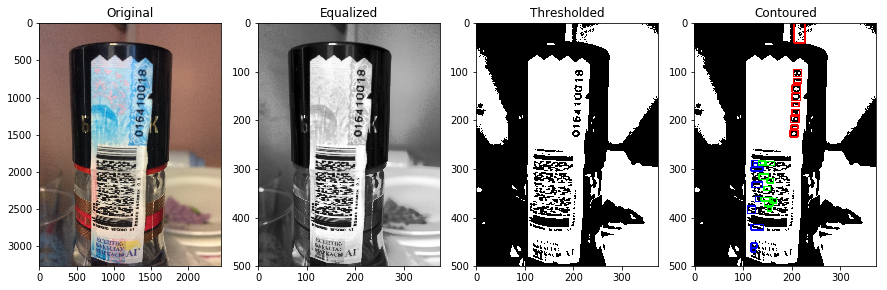

In [83]:
excise_src = cv2.imread("test_data/IMG_0307.JPG")
%time resized, equ, thresholded = excise_segmentation(excise_src)
%time contoured, ROICnts = select_contours(thresholded)

fig = plt.figure(figsize=(15, 15))

a = fig.add_subplot(1,4,1)
imgplot = plt.imshow(cv2.cvtColor(excise_src, cv2.COLOR_BGR2RGB))
a.set_title('Original')

a = fig.add_subplot(1,4,2)
imgplot = plt.imshow(cv2.cvtColor(equ, cv2.COLOR_GRAY2RGB))
a.set_title('Equalized')

a = fig.add_subplot(1,4,3)
imgplot = plt.imshow(cv2.cvtColor(thresholded, cv2.COLOR_GRAY2RGB))
a.set_title('Thresholded')

a = fig.add_subplot(1,4,4)
imgplot = plt.imshow(cv2.cvtColor(contoured, cv2.COLOR_BGR2RGB))
a.set_title('Contoured')

plt.show()

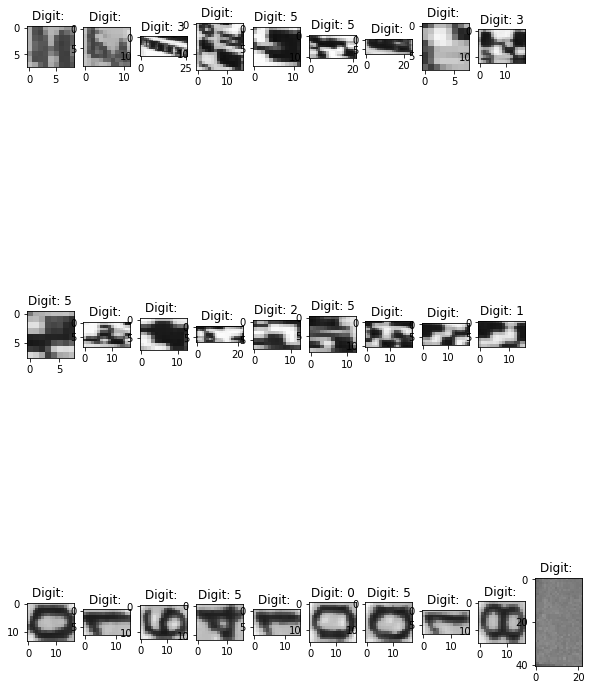

In [84]:
fig = plt.figure(figsize=(15, 15))

group = 0
for groupROICnts in ROICnts:
    contourIndex = 0
    currentGroupOrientation = groupROICnts['orientation']
    for c in groupROICnts['contours']:
        contourIndex += 1
        a = fig.add_subplot(len(ROICnts), 15, group * 15 + contourIndex)
        (x, y, w, h) = cv2.boundingRect(c)
        currentDigitCandidate = equ[y:y+h, x:x+w]
       
        recognized_digit = pytesseract.image_to_string(Image.fromarray(currentDigitCandidate, "L"), 
                                                       config="--tessdata-dir ./tessdata -psm 10 -l eng -c tessedit_char_whitelist=1234567890")
        imgplot = plt.imshow(cv2.cvtColor(currentDigitCandidate, cv2.COLOR_GRAY2RGB))
        a.set_title("Digit: " + str(recognized_digit))
    group += 1

plt.show()

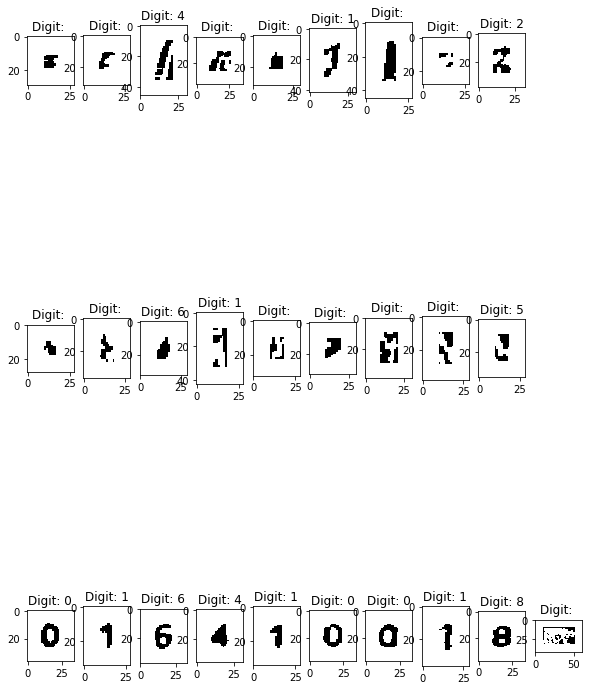

In [85]:
fig = plt.figure(figsize=(15, 15))

group = 0
for groupROICnts in ROICnts:
    contourIndex = 0
    currentGroupOrientation = groupROICnts['orientation']
    for c in groupROICnts['contours']:
        contourIndex += 1
        a = fig.add_subplot(len(ROICnts), 15, group * 15 + contourIndex)
        (x, y, w, h) = cv2.boundingRect(c)
        currentDigitCandidate = thresholded[y:y+h, x:x+w]
        if (currentGroupOrientation == 'vertical'):
            currentDigitCandidate = np.rot90(currentDigitCandidate, k=1, axes=(1,0))
        currentDigitCandidate = cv2.copyMakeBorder(currentDigitCandidate, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=[255,255,255])
        recognized_digit = pytesseract.image_to_string(Image.fromarray(currentDigitCandidate, "L"), 
                                                       config="--tessdata-dir ./tessdata -psm 10 -l eng -c tessedit_char_whitelist=1234567890")
        imgplot = plt.imshow(cv2.cvtColor(currentDigitCandidate, cv2.COLOR_GRAY2RGB))
        a.set_title("Digit: " + str(recognized_digit))
    group += 1

plt.show()

## Too slow :(

100%|██████████| 3/3 [00:00<00:00, 15.16it/s]

0: 126
0: 126
0: 129
1: 159
1: 159
1: 162
1: 169
1: 169
2: 214
2: 214
2: 214
2: 216
2: 217
2: 217
2: 219
2: 219
2: 221
2: 221


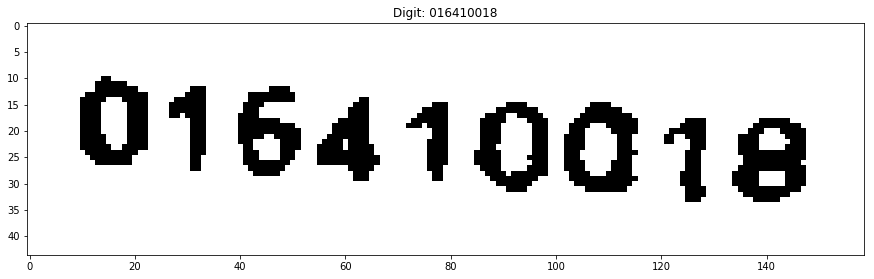

In [88]:
#resized, equ, thresholded = excise_segmentation(excise_src)
#_, ROICnts = select_contours(thresholded)

fig = plt.figure(figsize=(15, 15))

group = 0
for groupROICnts in tqdm(ROICnts):
    contourIndex = 0
    currentGroupOrientation = groupROICnts['orientation']
    (x, y, w, h) = cv2.boundingRect(groupROICnts['contours'][0])
    last_right = x
    last_top = y + h
    left = x
    top = y
    right = x + w
    bottom = y + h
    mergedContours = 0
    for c in groupROICnts['contours']:
        contourIndex += 1
        (x, y, w, h) = cv2.boundingRect(c)     
        
        if (currentGroupOrientation == 'horisontal'):
            if (x - last_right) > 10:  # already sorted and too big distance between chars
                if (mergedContours > 8) or (len(groupROICnts['contours']) < mergedContours + 9):
                    break
                else:  # start again
                    left = x
                    right = x + w
                    top = y
                    bottom = y + h
                    mergedContours = 1
            else:
                if x < left: left = x
                if (x + w > right): right = x + w
                if y < top: top = y
                if (y + h > bottom): bottom = y + h
                mergedContours += 1
                
        if (currentGroupOrientation == 'vertical'):
            if (last_top - y - h) > 10:  # already sorted and too big distance between chars
                if (mergedContours > 8) or (len(groupROICnts['contours']) < mergedContours + 9):
                    break
                else:  # start again
                    top = y
                    bottom = y + h
                    left = x
                    right = x + w
                    mergedContours = 1
            else:
                if y < top: top = y
                if (y + h > bottom): bottom = y + h
                if x < left: left = x
                if (x + w > right): right = x + w
                mergedContours += 1
                
        last_right = x + w
        last_top = y 
    
    group += 1
    if mergedContours < 9:
        continue
        
    _, currentDigitCandidate = cv2.threshold(equ[top:bottom, left:right], 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    a = fig.add_subplot(len(ROICnts), 1, group)
    if (currentGroupOrientation == 'vertical'):
        currentDigitCandidate = np.rot90(currentDigitCandidate, k=1, axes=(1,0))
    currentDigitCandidate = cv2.copyMakeBorder(currentDigitCandidate, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=[255,255,255])
    recognized_digit = pytesseract.image_to_string(Image.fromarray(currentDigitCandidate, "L"), 
                                               config="--tessdata-dir ./tessdata -psm 8 -oem 3 -c tessedit_char_whitelist=1234567890 nobatch digits")
    imgplot = plt.imshow(cv2.cvtColor(currentDigitCandidate, cv2.COLOR_GRAY2RGB))
    a.set_title("Digit: " + str(recognized_digit))

plt.show()